Aurélien Visentin - 023501

Eliot Leclair - 023484

## Imports and spark application setup

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as f
from pyspark.sql.functions import mean
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.dataframe import DataFrame
from pyspark.ml import Pipeline, Estimator
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import requests
import seaborn as sns

In [2]:
def create_spark_application(application_name: str) -> SparkSession:
    """
    Creates a spark application.
    """
    return SparkSession.builder.appName(application_name).getOrCreate()

In [3]:
if __name__ == "__main__":
    spark = create_spark_application("Spark_stocks_analysis")

## Exploration

### Summary of all the functions for the Exploration

**Functions for loading datasets:**

* read_paths(data_paths: dict, stocks_schema: StructType) -> dict:
    * Read all paths situated in the dictionary with format { stock_name: path }
    * Returns a `dict` with format { stock_name: DataFrame }

* load_stocks(root_data_folder_path="./stocks_data/") -> dict:
    * Reads the default provided stocks into a dict
    * Return a dict with a custom StructType

**Functions that show simple information about the dataset:**

* print_first_last_elements(df, df_name, elements_count=40) -> None:
    * Prints the first and last `elements_count` elements of the dataframe

* print_number_observations(df, df_name) -> None:
    * Prints the number of observations of the dataframe.

* get_date_difference(df, colname="Date") -> DataFrame:
    * Returns a dataframe that corresponds to the difference in days between each consecutive date.

* print_period(df, df_name, colname="Date") -> None:
    * Prints the period of the dataframe.

* print_dataset_description(df, df_name) -> None:
    * Prints descriptive statistics for each column of the `df` dataset

* print_missing_values_count(df, df_name) -> None:
    * Prints the missing values for each column of the `df` dataset.

**Functions that shows advanced information about the dataset:**

* compute_corr_matrix(df, numeric_cols: list):
    * Compute the correlation matrix of the `df` dataset using the `numeric_cols` columns. 

* print_corr_matrix(df, df_name, numeric_cols: list) -> None:
    * Prints the correlation matrix of the `df` dataset using the `numeric_cols` columns.
    
* plot_corr_matrixes(dataframes: dict, numeric_cols: list) -> None:
    * Creates a plot of the correlation between each dataframe in `dataframes`. 
    * Use `plt.show()` to display the plot after calling the function.
    
* get_daily_return_df(df, colname="daily_return") -> DataFrame:
    * Returns a copy of the `df` dataframe with a `colname` column corresponding to the daily return of the stocks.
    
* get_stocks_returns(stocks: dict, colname="daily_return", inplace=False) -> dict:
    * Sets the daily returns for each stocks in the `stocks` dictionary in a `colname` column.
    
* get_column_stats(df, colname) -> DataFrame:
    * Creates a dataframe corresponding to the statistics of a numeric column
    
* print_column_stats(df, df_name, colname) -> None:
    * Prints the statistics of a column in the `df` dataset.
    
* get_moving_average(df, colname="High", day_period=7) -> DataFrame:
    * Gets the moving average of the `df` dataset over `period days`
    
* print_moving_average(df, df_name, colname="High", day_period=7, show_count=5) -> None:
    * Prints the moving average of the dataframe.

* join_stocks(df1, df2, suffix1, suffix2):
    * Join two stocks by the `Date` column with an added suffix for the columns of each dataframe.

* correlate_stocks(df1, df2, suffix1, suffix2, cols_to_correlate) -> DataFrame:
    * Returns a Dataframe of the correlation between each column of the stocks `df1` and `df2`

* print_correlate_stocks(stock_dict, name1, i) -> None:
    * Prints the correlation of each matrix between them

* get_return_rate_by_period(df, date: str, period:str='week') -> int:
    * Gets the return rate on a set date for a defined period (week, month or year).
    
* get_best_stock_return_rate(stocks: dict, date: str, period:str ="month") -> tuple:
    * Gets the best return rate on a set date for a defined period (week, month or year). 
    * Returns the key of the `stocks` dict and its return rate.
    
* print_return_rate_by_period(df, df_name: str, date: str, period: str="month") -> None:
    * Prints the return rate on a set date for a defined period (week, month or year).
* print_best_return_rate_by_period(stocks: dict, date: str, period: str) -> None:
    * Prints the best return rate on a set date for a defined period (week, month or year).

### Functions for loading datasets

In [4]:
def read_paths(data_paths: dict, stocks_schema: StructType) -> dict:
    """
    Read all paths situated in the dictionary with format { stock_name : path }
    :returns a dict with format { stock_name : DataFrame }
    """
    stocks = {}
    for k, v in data_paths.items():
        current_df = spark.read.csv(v, header=True, schema=stocks_schema)
        stocks[k] = current_df

    return stocks


def load_stocks(root_data_folder_path="./stocks_data/") -> dict:
    """
    Reads the default provided stocks into a dict.
    """

    data_paths = {
        "amazon": root_data_folder_path + "AMAZON.csv",
        "apple": root_data_folder_path + "APPLE.csv",
        "facebook": root_data_folder_path + "FACEBOOK.csv",
        "google": root_data_folder_path + "GOOGLE.csv",
        "microsoft": root_data_folder_path + "MICROSOFT.csv",
        "tesla": root_data_folder_path + "TESLA.csv",
        "zoom": root_data_folder_path + "ZOOM.csv"
    }

    stocks_schema = StructType([
        StructField("Date", DateType()),
        StructField("High", DoubleType()),
        StructField("Low", DoubleType()),
        StructField("Open", DoubleType()),
        StructField("Close", DoubleType()),
        StructField("Volume", DecimalType()),
        StructField("Adj Close", DoubleType()),
        StructField("company_name", StringType()),
    ])

    return read_paths(data_paths, stocks_schema)

### Functions that show simple information about the dataset

In [5]:
def print_first_last_elements(df, df_name, elements_count=40) -> None:
    """
    Prints the first and last `elements_count` elements of the dataframe.
    """
    print(f"Showing the first and last {elements_count} rows of the {df_name.capitalize()} dataframe:")
    df.show(elements_count)
    spark.createDataFrame(df.tail(elements_count)).show(elements_count)

def print_number_observations(df, df_name) -> None:
    """
    Prints the number of observations of the dataframe.
    """
    print(f"The {df_name.capitalize()} dataframe contains {df.count()} observations.")
    print()

def get_date_difference(df, colname="Date") -> DataFrame:
    """
    Returns a dataframe that corresponds to the difference in days between each consecutive date.
    """
    window = Window.partitionBy(f.lit(0)).orderBy(f.col(colname).asc())

    return df.withColumn(colname, f.datediff(f.col(colname), f.lag(f.col(colname), 1).over(window)))

def print_period(df, df_name, colname="Date") -> None:
    """
    Prints the period of the dataframe.
    """
    date_diff_df = get_date_difference(df, colname)
    period_mat = date_diff_df.agg(
        f.percentile_approx(colname, 0.5).alias("Median period"),
        f.mean(colname).alias("Mean period"), 
    ).collect()

    print(f"The period between points of the {df_name.capitalize()} dataset is:")
    print(f"\t{period_mat[0][0]} days (median)")
    print(f"\t{period_mat[0][1]} days (on average)")
    print()

def print_dataset_description(df, df_name) -> None:
    """
    Prints descriptive statistics for each column of the `df` dataset 
    """
    print(f"Statistics for {df_name.capitalize()} dataframe:")
    df.describe().show()

def print_missing_values_count(df, df_name) -> None:
    """
    Prints the missing values for each column of the `df` dataset. 
    """
    print(f"Missing values for {df_name.capitalize()}:")
    df.select(*[
        (
            f.count(f.when((f.isnan(c) | f.col(c).isNull()), c)) if t not in ("timestamp", "date")
            else f.count(f.when(f.col(c).isNull(), c))
        ).alias(c)
        for c, t in df.dtypes if c in df.columns
    ]).show()

### Functions that shows advanced information about the dataset.

In [6]:

def compute_corr_matrix(df, numeric_cols: list):
    """
    Compute the correlation matrix of the `df` dataset using the `numeric_cols` columns. 
    """
    # convert to vector column first
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)

    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
    return cor_np

def print_corr_matrix(df, df_name, numeric_cols: list) -> None:
    """
    Prints the correlation matrix of the `df` dataset using the `numeric_cols` columns.
    """
    mat = compute_corr_matrix(df, numeric_cols)
    print(f"Correlation matrix for {df_name.capitalize()}")
    print(f"Columns are: {numeric_cols}")
    print(mat)
    print()

def plot_corr_matrixes(dataframes: dict, numeric_cols: list) -> None:
    """
    Creates a plot of the correlation between each dataframe in `dataframes`. 
    Use `plt.show()` to display the plot after calling the function.
    """
    fig, axs = plt.subplots(len(dataframes), 1, figsize=(5, 15), layout='constrained')

    for i, df_name in enumerate(dataframes):
        mat = compute_corr_matrix(dataframes[df_name], numeric_cols)
        upp_mat = np.triu(mat)
        sns.heatmap(mat, vmin = -1, vmax = +1, annot = True, cmap = 'Blues', mask = upp_mat, ax=axs[i], label=df_name)
        axs[i].set_title(df_name.capitalize(), size = 15)


def get_daily_return_df(df, colname="daily_return") -> DataFrame:
    """
    Returns a copy of the `df` dataframe with a `colname` column corresponding to the daily return of the stocks.
    """
    return df.withColumn(colname, df["Close"] - df["Open"])

def get_stocks_returns(stocks: dict, colname="daily_return", inplace=False) -> dict:
    """
    Sets the daily returns for each stocks in the `stocks` dictionary in a `colname` column.
    """
    res = stocks
    if not inplace:
        res = dict()
    for name in stocks:
        res[name] = get_daily_return_df(stocks[name], colname)
    return res

def get_column_stats(df, colname) -> DataFrame:
    """
    Creates a dataframe corresponding to the statistics of a numeric column
    """
    return df.agg(*[
            f.first("company_name").alias("company_name"),
            f.mean(colname).alias(f"mean({colname})"),
            f.percentile_approx(colname, 0.5).alias(f"median({colname})"),
            f.stddev(colname).alias(f"stddev({colname})"),
        ])

def print_column_stats(df, df_name, colname) -> None:
    """
    Prints the statistics of a column in the `df` dataset.
    """
    print(f"The statistics of the {colname} column in the {df_name.capitalize()} dataset are:")
    get_column_stats(df, colname).show()

### Moving average

In [7]:
DAY_IN_SECONDS = 86400 # 24 * 60 * 60

def get_moving_average(df, colname="High", day_period=7) -> DataFrame:
    """
    Gets the moving average of the `df` dataset over `period days`
    """
    # window = Window.orderBy(col('Date').cast('timestamp').cast('long'))
    window = Window.partitionBy(f.lit(0)).orderBy(col('Date').cast('timestamp').cast('long'))
    window.rangeBetween(-(day_period * DAY_IN_SECONDS) - 1, 0)
    df_ma = df.select('*')
    return df_ma.select(col('*'), mean(colname).over(window).alias('Moving_average'))

def print_moving_average(df, df_name, colname="High", day_period=7, show_count=5) -> None:
    """
    Prints the moving average of the dataframe.
    """
    moving_average_df = get_moving_average(df, colname, day_period)
    print(f"The moving average of the {df_name} dataframe on {day_period} days is:")
    moving_average_df.show(show_count)

### Correlation

In [8]:
def join_stocks(df1, df2, suffix1, suffix2) -> DataFrame:
    """
    Join two stocks by the `Date` column with an added suffix for the columns of each dataframe.
    """
    df1_r = df1.select(*(col(x).alias(x + suffix1) for x in df1.columns))
    df2_r = df2.select(*(col(x).alias(x + suffix2) for x in df2.columns))
    joined_df = df1_r.join(df2_r, on=df1_r["Date" + suffix1] == df2_r["Date" + suffix2])
    # Cleaning memory
    df1_r.unpersist(False)
    df2_r.unpersist(False)

    return joined_df

def correlate_stocks(df1, df2, suffix1, suffix2, cols_to_correlate) -> DataFrame:
    """
    Returns a Dataframe of the correlation between each column of the stocks `df1` and `df2`
    """
    joined_df = join_stocks(df1, df2, suffix1, suffix2)
    res = []
    cols1 = [f"{c}{suffix1}" for c in cols_to_correlate]
    cols2 = [f"{c}{suffix2}" for c in cols_to_correlate]
    for c1 in cols1:
        current = [c1] + [joined_df.corr(c1, c2) for c2 in cols2]
        res.append(current)
    # Cleaning memory
    joined_df.unpersist(False)
    return spark.createDataFrame(res, ["Col" + suffix1] + cols2)

def print_correlate_stocks(stocks_dict, name, idx, numeric_cols) -> None:
    """
    Prints the correlation of each matrix between them
    """
    for name2 in list(stocks_dict)[idx + 1:]:
        print(f"========= Correlation between {name.capitalize()} and {name2.capitalize()} =========")
        tmp = correlate_stocks(stocks_dict[f"{name}"], stocks_dict[f"{name2}"], f"_{name}", f"_{name2}", numeric_cols)
        tmp.show()
        tmp.unpersist(False)

###  Return rates

In [9]:
def get_return_rate_by_period(df, date: str, period:str='week') -> int:
    """
    Gets the return rate on a set date for a defined period (week, month or year).
    """
    periods = {'week': 7, 'month': 30, 'year': 365}
    if period not in periods:
        raise ValueError(f"Invalid period: {period}")

    date_col = f.lit(date)

    reduced_df = df.where(f.col("Date") >= date_col).where(f.col("Date") < f.date_add(date_col, periods[period]))

    return reduced_df.select(f.last("Close") - f.first("Close")).collect()[0][0]


def get_best_stock_return_rate(stocks: dict, date: str, period:str ="month") -> tuple:
    """
    Gets the best return rate on a set date for a defined period (week, month or year). 
    Returns the key of the `stocks` dict and its return rate.
    """
    rates = {
        name: get_return_rate_by_period(stock, date, period) for name, stock in stocks.items()
    }
    max_key = max(rates, key=rates.get)
    return max_key, rates[max_key]


def print_return_rate_by_period(df, df_name: str, date: str, period: str="month") -> None:
    """
    Prints the return rate on a set date for a defined period (week, month or year).
    """
    rate = get_return_rate_by_period(df, date, period)
    print(f"The return rate of the {df_name} dataframe from the {date} on {period} days is: {rate}.")
    print()


def print_best_return_rate_by_period(stocks: dict, date: str, period: str) -> None:
    """
    Prints the best return rate on a set date for a defined period (week, month or year). 
    """
    stock_name, rate = get_best_stock_return_rate(stocks, date, period)
    print(f"The best return rate from the {date} with a '{period}' period is: {stock_name} with a rate of {rate}.")
    print()

### Insights

#### Modern Portfolio Theory (MPT):
Method to select investments in order to maximize their returns with a low level of risks.

#### Risk Parity
Find the portfolio that equalizes the risk contribution of portfolio assets

#### REST API Call
The functions defined below allow us to make a call to a REST API to load data stored online and to be used in spark.

#### Bollinger Band:
This method helps determine whether prices are high or low on a relative basis.

#### Autoregressive Integrated Moving Average (ARIMA):
Model using the precedently implemented moving average in stock prices in order to perform regression and predict future evolutions.

#### Moving Average Convergence Divergence (MACD):
MACD is a trend-following momentum indicator that shows the relationship between two moving averages, a short term and a long term.

#### Value at Risk (VaR):
A statistic that quantifies the extent of possible financial losses within a firm.

#### Aroon oscillator:
Describes the general tendency of the stock price evolution, whether it is going up or down.

#### Modern Portfolio Theory

The modern portfolio theory, made by Harry Markowitz, is a method to select investments in order to maximize their returns with a low level of risks.

It works by making a weighted sum of the portfolio's investment proportions with their expected returns:

`expected_return = investment_ratio_A * expected_returns_A + investment_ratio_B * expected_returns_B + ...`

We do not have a portfolio for the moment, but the function below can be used for fake ones.

For example, the following code: 

```python
portfolio = spark.createDataFrame(
    [
        ("apple", 10., 0.04),
        ("facebook", 10., 0.06),
        ("amazon", 10., 0.1),
        ("microsoft", 10., 0.14)
    ],
    schema=portfolio_schema
)
portfolio.show()

returns_ratio = modern_portfolio_theory_expected_returns(portfolio)

print(f"We expect {returns_ratio * 100}% of returns")
```
Will output:
```
+------------+-----------------+---------------+
|company_name|investment_amount|expected_return|
+------------+-----------------+---------------+
|       apple|             10.0|           0.04|
|    facebook|             10.0|           0.06|
|      amazon|             10.0|            0.1|
|   microsoft|             10.0|           0.14|
+------------+-----------------+---------------+

We expect 8.5% of returns
```

In [10]:
portfolio_schema = StructType([
    StructField("company_name", StringType()),
    StructField("investment_amount", DoubleType()),
    StructField("expected_return", DoubleType()),
])

def modern_portfolio_theory_expected_returns(portfolio):
    """
    The portfolio must have a schema of portfolio_schema.
    """
    df = portfolio.withColumn(
        "investment_ratio", 
        f.col("investment_amount") / f.sum("investment_amount").over(Window.partitionBy(f.lit(0)))
    )
    ratio_df = df.select((f.col("investment_ratio") * col("expected_return")).alias("product")).select(f.sum("product"))
    return ratio_df.collect()[0][0] # Only one value

#### Risk Parity

Risk parity is a portfolio allocation strategy that uses risk to determine allocations across various components of an investment portfolio. The risk parity strategy modifies the modern portfolio theory (MPT) approach to investing through the use of leverage.

Risk parity is an advanced portfolio technique often used by hedge funds and sophisticated investors. It requires a complex quantitative methodology, which makes its allocations more advanced than simplified allocation strategies. The goal of risk parity investing is to earn the optimal level of return at the targeted risk level.

#### REST API Call
The functions defined below allow us to make a call to a REST API. It allows us to load data stored online and make queries to endpoints if needed.

To use these, we need to create a schema of what the API will return. For example:

```python
schema = StructType([
  StructField("message", StringType(), True),
  StructField("result", ArrayType(
    StructType([
      StructField("Column1", IntegerType()),
      StructField("Column2", StringType())
    ])
  ))
])
```

Next, we call the `create_response_dataframe_from_rest(url, schema, headers=None, body=None)` function with the URL of the endpoint and the schema we created. We can also pass HTTP headers or a JSON Body to make specific requests.

The resulting dataframe will be composed of the following columns: `("verb", "url", "headers", "body", "result")`

The result column will be a structure following our schema. In addition, the call to the API will only be made when the dataset is computed, hence not utilizing resources from the master if the dataset is big. 

Stocks can contain lots of data, it might not be a good idea to load and store the datasets on the disk and it is sometimes easier to just call an endpoint at times.

In [11]:
def call_rest_api(verb, url, headers=None, body=None):
    """
    Execute a REST API call to an URL.
    Function type and parameters are defined by pyspark.
    """
    if headers is None:
        headers = { 'content-type': "application/json" }
    if body is None:
        body = json.dumps({})

    try:
        if verb.lower() == "get":
            res = requests.get(url, data=body, headers=headers)
        else:
            res = requests.post(url, data=body, headers=headers)
            
        if res is None or res.status_code != 200:
            return None
        
        return json.loads(res.text)
    except Exception as e:
        return e


def create_response_dataframe_from_rest(url, schema, headers=None, body=None):
    """
    Create a dataframe from a rest API.
    It will have the following columns ("verb", "url", "headers", "body", "result")
    The result column will follow the schema passed as a parameter.
    The API call will be made only when it is used (lazy, we use a Spark User Defined Function - udf).
    """
    if headers is None:
        headers = { 'content-type': "application/json" }
    if body is None:
        body = json.dumps({})

    call_rest_api_udf = f.udf(call_rest_api, schema)

    request_api_rows = Row("verb", "url", "headers", "body")

    request_df = spark.createDataFrame([
            request_api_rows("get", url, headers, body)
          ])
    
    result_df = request_df.withColumn(
        "result", 
        call_rest_api_udf(col("verb"), col("url"), col("headers"), col("body"))
    )
    return result_df

#### Bollinger Bands 
Bollinger Bands are a type of price envelope developed by John BollingerOpens in a new window.   
Bollinger Bands are envelopes plotted at a standard deviation level above and below a simple moving average of the price.   
This method helps determine whether prices are high or low on a relative basis.

#### Arima
An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. 

A statistical model is autoregressive if it predicts future values based on past values. For example, an ARIMA model might seek to predict a stock's future prices based on its past performance or forecast a company's earnings based on past periods.

```python
from statsmodels.tsa.arima.model import ARIMA

stocks = load_stocks()
arima_model = ARIMA(dataframe)
model = arima_model.fit()
print(model.summary())
```

#### Moving Average Convergence Divergence
MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell—or short—the security when the MACD crosses below the signal line. Moving average convergence divergence (MACD) indicators can be interpreted in several ways, but the more common methods are crossovers, divergences, and rapid rises/falls.

#### Value at Risk
VaR modeling determines the potential for loss in the entity being assessed and the probability that the defined loss will occur. One measures VaR by assessing the amount of `potential loss`, the probability of occurrence for the amount of loss, and the timeframe.

#### Aroon Oscillator
The Aroon Oscillator is a trend-following indicator that uses aspects of the Aroon Indicator to gauge the strength of a current trend and the likelihood that it will continue.

Aroon oscillator readings above zero indicate that an uptrend is present, while readings below zero indicate that a downtrend is present. Traders watch for zero line crossovers to signal potential trend changes. They also watch for big moves, above 50 or below -50 to signal strong price moves.

### Calling main code

In [12]:
def main_exploration():
    stocks = load_stocks()
    numeric_cols = ["High","Low","Open","Close","Volume","Adj Close"]
    

    get_stocks_returns(stocks, "daily_return", inplace=True) # We compute the daily returns and add it to a new column
    
    for index, (name, stock) in enumerate(stocks.items()):
        print(f"------------ EXPLORATION OF THE <{name.upper()}> DATAFRAME ------------")
        print_first_last_elements(stock, name)
        print_number_observations(stock, name)
        print_period(stock, name)
        print_dataset_description(stock, name)
        print_missing_values_count(stock, name)
        print_corr_matrix(stock, name, numeric_cols)
        print_column_stats(stock, name, "daily_return")
        print_moving_average(stock, name, day_period=31)
        print_correlate_stocks(stocks, name, index, numeric_cols)
        print_return_rate_by_period(stock, name, "2020-01-01", "month")
    
    print(f"------------ EXPLORATION STATS OF ALL DATAFRAMES ------------")
    print_best_return_rate_by_period(stocks, "2020-01-01", "month")

if __name__ == "__main__":
    main_exploration()

------------ EXPLORATION OF THE <AMAZON> DATAFRAME ------------
Showing the first and last 40 rows of the Amazon dataframe:
+----------+-----------------+-----------------+-----------------+-----------------+--------+-----------------+------------+-----------------+
|      Date|             High|              Low|             Open|            Close|  Volume|        Adj Close|company_name|     daily_return|
+----------+-----------------+-----------------+-----------------+-----------------+--------+-----------------+------------+-----------------+
|2017-01-03| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562| 3521100|753.6699829101562|      AMAZON|            -4.25|
|2017-01-04|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812| 2510500|757.1799926757812|      AMAZON|-1.21002197265625|
|2017-01-05|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312| 5830100|780.4500122070312|      AMAZON| 18.9000244140625|
|2017-01-06|799.44

/opt/python/envs/default/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Regression

### Summary of all the functions for the Regression

**Functions for loading datasets:**

* join_datasets(stocks: dict) -> DataFrame:
    * Joins all stocks into one dataset

* convert_date_to_double(df: DataFrame, colname: str) -> DataFrame:
    * Convert a date column into a double

* convert_double_to_date(df: DataFrame, colname: str) -> DataFrame:
    * Convert a double column into a date

* create_vector_assembler(features: list, output_name: str= "features") -> VectorAssembler:
    * Creates a vector assembler for numerical columns

* linear_regressor(features: list, pred_col: str = "Adj Close") -> Pipeline:
    * Creates a linear regressor pipeline
    
* decision_tree_regressor(features: list, pred_col: str= "Adj Close", max_bins: int=MAX_BIN_DEFAULT) -> Estimator:
    * Creates a decision tree regressor pipeline
    
* random_forest_regressor(features: list, pred_col: str= "Adj Close", max_bins: int=MAX_BIN_DEFAULT) -> Estimator:
    * Creates a random forest regressor pipeline

* tuned_random_forest_regressor(features: list, pred_col: str= "Adj Close", max_bins: int=MAX_BIN_DEFAULT) -> Estimator:
    * Creates a random forest regressor pipeline tuned using CrossValidator
    
* plot_prediction(df: DataFrame, x_col: str, real_col: str, pred_col: str, curve_name: str, plot_title: str=None) -> None:
    * Plots the predictions of a model
    
    

In [13]:
MAX_BIN_DEFAULT = 64

def join_datasets(stocks: dict) -> DataFrame:
    """
    Joins all stocks into one dataset
    """
    names = iter(stocks.keys())
    df = stocks[next(names)]
    for name in names:
        df = df.union(stocks[name])
    return df

def date_to_double(df: DataFrame, colname: str) -> DataFrame:
    """
    Convert a date column into a double
    """
    return df.withColumn(colname, col(colname).cast("timestamp").cast("double"))

def double_to_date(df: DataFrame, colname: str) -> DataFrame:
    """
    Convert a double column into a date
    """
    return df.withColumn(colname, col(colname).cast("timestamp").cast("date"))

def create_vector_assembler(features: list, output_name: str= "features") -> VectorAssembler:
    """
    Creates a vector assembler for numerical columns
    """
    return VectorAssembler(inputCols=features, outputCol=output_name)

def linear_regressor(features: list, pred_col: str = "Adj Close") -> Pipeline:
    """
    Creates a linear regressor pipeline
    """
    vec_assembler = create_vector_assembler(features)
    lr = LinearRegression(featuresCol="features", labelCol=pred_col)
    
    return Pipeline(stages=[vec_assembler, lr])

def decision_tree_regressor(features: list, pred_col: str= "Adj Close", max_bins: int=MAX_BIN_DEFAULT) -> Estimator:
    """
    Creates a decision tree regressor pipeline
    """
    vec_assembler = create_vector_assembler(features)
    dt = DecisionTreeRegressor(labelCol=pred_col)
    dt.setMaxBins(max_bins)

    return Pipeline(stages=[vec_assembler, dt])

def random_forest_regressor(features: list, pred_col: str= "Adj Close", max_bins: int=MAX_BIN_DEFAULT) -> Estimator:
    """
    Creates a random forest regressor pipeline
    """
    vec_assembler = create_vector_assembler(features)
    rf = RandomForestRegressor(labelCol=pred_col, maxBins=max_bins, seed=123)

    return Pipeline(stages=[vec_assembler, rf])

def tuned_random_forest_regressor(features: list, pred_col: str= "Adj Close", max_bins: int=MAX_BIN_DEFAULT) -> Estimator:
    """
    Creates a random forest regressor pipeline tuned using CrossValidator
    """
    vec_assembler = create_vector_assembler(features)
    rf = RandomForestRegressor(labelCol=pred_col, maxBins=max_bins, seed=123)

    pipeline = Pipeline(stages=[vec_assembler, rf])

    param_grid = (ParamGridBuilder()
                  .addGrid(rf.maxDepth, [2, 4, 6, ])
                  .addGrid(rf.numTrees, [10, 100])
                  .build())
    evaluator = RegressionEvaluator(
        labelCol=pred_col,
        predictionCol="prediction",
        metricName="rmse"
    )
    cv = CrossValidator(
        estimator=pipeline,
        evaluator=evaluator,
        estimatorParamMaps=param_grid,
        numFolds=3,
        seed=123
    )
    return cv

def plot_prediction(trainDF, testDF, x_col: str, real_col: str, pred_col: str, model_name: str, title: str) -> None:
    """
    Plots the predictions of a model
    """
    plt.figure(figsize=(20,10))
    plt.title(title)


    get_x = lambda df: df.select(x_col).collect()

    if trainDF is not None:
        trainDF = trainDF.orderBy(x_col)
        x_val_train = get_x(trainDF)
        plt.plot(x_val_train, trainDF.select(real_col).collect(), label=f"train({real_col})")
        plt.plot(x_val_train, trainDF.select(pred_col).collect(), label=f"train({model_name})")

    if testDF is not None:
        testDF = testDF.orderBy(x_col)
        x_val_test = get_x(testDF)
        plt.plot(x_val_test, testDF.select(real_col).collect(), label=f"test({real_col})")
        plt.plot(x_val_test, testDF.select(pred_col).collect(), label=f"test({model_name})")

    plt.legend()
    plt.show()


In [14]:

def predict_and_plot_stock(name, stock, models, features, split_ratio=0.2):
    stock = date_to_double(stock, "Date")

    stock_len = stock.count()
    testDF = spark.createDataFrame(stock.tail(int(stock_len * split_ratio)))
    trainDF = stock.subtract(testDF)
    # trainDF, testDF = stock.randomSplit([8., 2.], seed=123) is not used because we want to predict the future.

    for model in models:
        pipeline = model(features, "Adj Close")
        pipelineModel = pipeline.fit(trainDF)
        pred_test = double_to_date(pipelineModel.transform(testDF), "Date")
        pred_train = double_to_date(pipelineModel.transform(trainDF), "Date")
        plot_prediction(pred_train, pred_test, "Date", "Adj Close", "prediction", model.__name__, f"{name.capitalize()}: {model.__name__}")

        pred_test.unpersist(False)
        pred_train.unpersist(False)

def main_regression():
    stocks = load_stocks()
    # We do not use tuned_random_forest_regressor since random forest is not a good model for this data
    # and the algorithm is very expensive to train and compute
    models = [linear_regressor, decision_tree_regressor, random_forest_regressor]
    features = ["Date", "Open"]

    for name, stock in stocks.items():
        predict_and_plot_stock(name, stock, models, features)

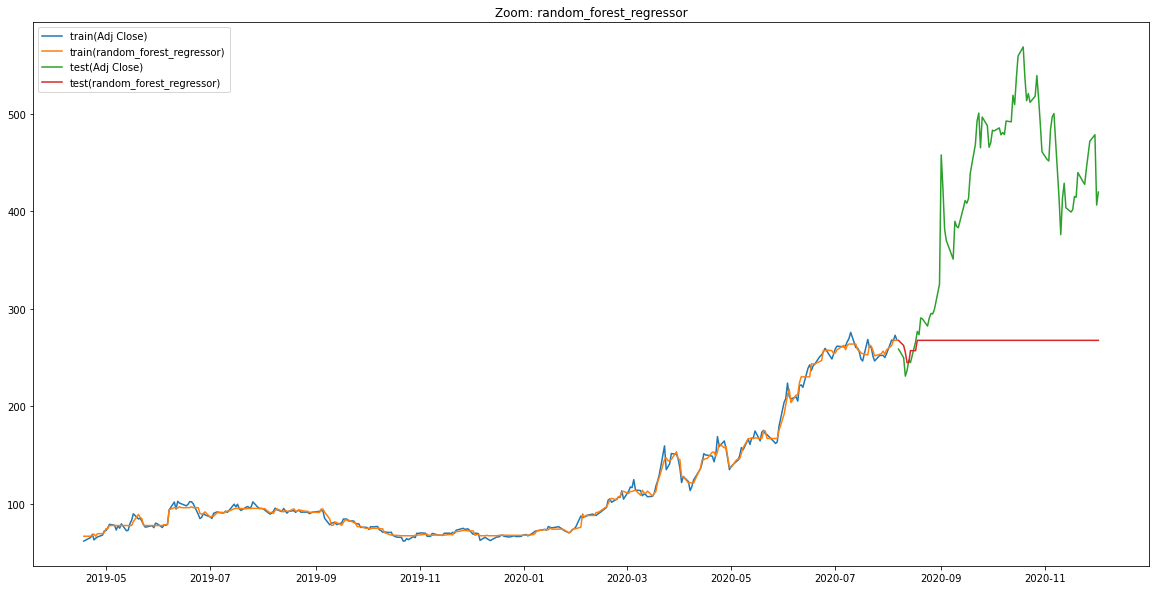

In [15]:
if __name__ == "__main__":
    main_regression()